# Data Preprocessing

This notebook is for data acquisition(conversion to MNE) and preprocessing the data with basic steps as follows:
1. Data Aquisition
2. Exploratory analysis
3. Preprocessing
    - Filtering
    - Artifact Removal
    - Epoching
    - Normalisation
4. Optimizations

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne

# For loading .mat files
import scipy.io as sio
import h5py

# For artifact removal
from mne.preprocessing import ICA

# For visualising
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Set aesthetic style for plots
sns.set_theme(style="whitegrid", palette="viridis", font_scale=1.2)

# Check basic system details to monitor resource usage
import platform
print("Running on:", platform.platform())

Running on: macOS-15.3.2-arm64-arm-64bit


### Folder structure and file paths

In [2]:
subject_id = 2
data_root = "./data/raw/"
subject_folder = f"Sub{subject_id}"
eeg_folder = os.path.join(data_root, subject_folder, "EEG")

cnt_file = os.path.join(eeg_folder, "cnt.mat")
mrk_file = os.path.join(eeg_folder, "mrk.mat")

# Check existence
if not os.path.exists(cnt_file):
    raise FileNotFoundError(f"Cannot find {cnt_file}. Please check your dataset path.")
if not os.path.exists(mrk_file):
    raise FileNotFoundError(f"Cannot find {mrk_file}. Please check your dataset path.")

### Loading the mat files

loading data and extracting the following
- EEG data array
- sampling frequency
- channel names
- event information from mrk.mat files

In [3]:
try:
    cnt_mat = sio.loadmat(cnt_file, struct_as_record=False, squeeze_me=True)
    mrk_mat = sio.loadmat(mrk_file, struct_as_record=False, squeeze_me=True)
    print("Loaded CNT file with sio")
except NotImplementedError:
    try:
        cnt_mat = h5py.File(cnt_file, mode="r")
        mrk_mat = h5py.File(mrk_file, mode="r")
        print("Files loaded successfully with h5py")
    except Exception as e:
        print(f"Error loading files: {e}")


# Inspect top-level keys (sometimes the actual data is nested deeper)
print("CNT.mat keys:", cnt_mat.keys())
print("MRK.mat keys:", mrk_mat.keys())

Files loaded successfully with h5py
CNT.mat keys: <KeysViewHDF5 ['#refs#', 'cnt']>
MRK.mat keys: <KeysViewHDF5 ['#refs#', 'mrk']>


In [4]:
print(cnt_mat["cnt"].keys())

<KeysViewHDF5 ['EEG', 'Gender', 'HumanFactor', 'clab', 'fs']>


In [5]:
print(mrk_mat["mrk"].keys())

<KeysViewHDF5 ['className', 'event', 'time', 'y']>


In [6]:
# Extracting data from cnt.mat
eeg_data = np.array(cnt_mat["cnt"]["EEG"][()])
fs = np.array(cnt_mat["cnt"]["fs"][()]).item()  # Convert to a Python scalar
clab = np.array(cnt_mat["cnt"]["clab"][()])

In [7]:
# Decode channel labels if they're stored as bytes
if clab.dtype.kind == 'S':
    clab = [s.decode('utf-8') for s in clab]
else:
    clab = list(clab)

print("EEG data shape:", eeg_data.shape)
print("Sampling frequency:", fs)
print("Channel labels:", clab)

EEG data shape: (3691800, 63)
Sampling frequency: 1000.0
Channel labels: [array([<HDF5 object reference>], dtype=object), array([<HDF5 object reference>], dtype=object), array([<HDF5 object reference>], dtype=object), array([<HDF5 object reference>], dtype=object), array([<HDF5 object reference>], dtype=object), array([<HDF5 object reference>], dtype=object), array([<HDF5 object reference>], dtype=object), array([<HDF5 object reference>], dtype=object), array([<HDF5 object reference>], dtype=object), array([<HDF5 object reference>], dtype=object), array([<HDF5 object reference>], dtype=object), array([<HDF5 object reference>], dtype=object), array([<HDF5 object reference>], dtype=object), array([<HDF5 object reference>], dtype=object), array([<HDF5 object reference>], dtype=object), array([<HDF5 object reference>], dtype=object), array([<HDF5 object reference>], dtype=object), array([<HDF5 object reference>], dtype=object), array([<HDF5 object reference>], dtype=object), array([<HDF5 o

In [8]:
# Extracting marker information from mrk.mat
mrk_time = np.array(mrk_mat["mrk"]["time"][()])
mrk_y = np.array(mrk_mat["mrk"]["y"][()])
# mrk_event = np.array(mrk_mat["mrk"]["event"][()])
# because the above shows an error for the group
event_field = mrk_mat["mrk"]["event"]
if isinstance(event_field, h5py.Dataset):
    mrk_event = np.array(event_field[()])
elif isinstance(event_field, h5py.Group):
    # Inspect the group keys to decide what to extract
    event_keys = list(event_field.keys())
    print("Event group keys:", event_keys)
    # If there's only one key, we assume that's our data.
    if len(event_keys) == 1:
        mrk_event = np.array(event_field[event_keys[0]][()])
    else:
        # Otherwise, choose a key or combine data as needed.
        # For now, we select the first key.
        mrk_event = np.array(event_field[event_keys[0]][()])
else:
    mrk_event = None

Event group keys: ['chan', 'desc', 'length', 'type']


In [9]:
# Extracting classname info
mrk_className = np.array(mrk_mat["mrk"]["className"][()])
if mrk_className.dtype.kind == 'S':
    mrk_className = [s.decode('utf-8') for s in mrk_className]
else:
    mrk_className = list(mrk_className)

print("Marker times shape:", mrk_time.shape)
print("Marker y shape:", mrk_y.shape)
if mrk_event is not None:
    print("Marker event shape:", mrk_event.shape)
print("Marker class names:", mrk_className)

Marker times shape: (160, 1)
Marker y shape: (160, 2)
Marker event shape: (1, 160)
Marker class names: [array([<HDF5 object reference>], dtype=object), array([<HDF5 object reference>], dtype=object)]


In [10]:
# Sampling rate
sfreq = fs # creating a copy of the variable here
print("Sampling frequency:", sfreq)

Sampling frequency: 1000.0


In [11]:
n_channels = eeg_data.shape[1]
channel_names = [f"EEG{i}" for i in range(n_channels)]
print("Channel names:", channel_names)

Channel names: ['EEG0', 'EEG1', 'EEG2', 'EEG3', 'EEG4', 'EEG5', 'EEG6', 'EEG7', 'EEG8', 'EEG9', 'EEG10', 'EEG11', 'EEG12', 'EEG13', 'EEG14', 'EEG15', 'EEG16', 'EEG17', 'EEG18', 'EEG19', 'EEG20', 'EEG21', 'EEG22', 'EEG23', 'EEG24', 'EEG25', 'EEG26', 'EEG27', 'EEG28', 'EEG29', 'EEG30', 'EEG31', 'EEG32', 'EEG33', 'EEG34', 'EEG35', 'EEG36', 'EEG37', 'EEG38', 'EEG39', 'EEG40', 'EEG41', 'EEG42', 'EEG43', 'EEG44', 'EEG45', 'EEG46', 'EEG47', 'EEG48', 'EEG49', 'EEG50', 'EEG51', 'EEG52', 'EEG53', 'EEG54', 'EEG55', 'EEG56', 'EEG57', 'EEG58', 'EEG59', 'EEG60', 'EEG61', 'EEG62']


In [12]:
# MNE expects shape (n_channels, n_times)
print(f"eeg data shape: {eeg_data.shape}")

eeg data shape: (3691800, 63)


In [13]:
# because the data is (n_samples, n_channels) we transpose for mne
eeg_data = eeg_data.T
print("After transpose, EEG data shape:", eeg_data.shape)

After transpose, EEG data shape: (63, 3691800)


### Creating MNE rawarrays

This will help us in subsequent preprocessing of the dataset

In [14]:
info = mne.create_info(ch_names=channel_names, sfreq=sfreq, ch_types='eeg')
raw = mne.io.RawArray(eeg_data, info)
print(raw)

Creating RawArray with float64 data, n_channels=63, n_times=3691800
    Range : 0 ... 3691799 =      0.000 ...  3691.799 secs
Ready.
<RawArray | 63 x 3691800 (3691.8 s), ~1.73 GB, data loaded>


### Parsing event markers

In [15]:
# flattening the mark arrays
mrk_time = mrk_time.flatten()
mrk_event = mrk_event.flatten()

In [16]:
# Constructing the MNE events array
events = np.column_stack((mrk_time.astype(int), np.zeros(len(mrk_time), dtype=int), mrk_event.astype(int)))
print("Constructed events array shape:", events.shape)
print("First 5 events:\n", events[:5])

Constructed events array shape: (160, 3)
First 5 events:
 [[ 28024      0      0]
 [ 29420      0      0]
 [ 82903      0      0]
 [ 83989      0      0]
 [133910      0      0]]


Using matplotlib as 2D backend.


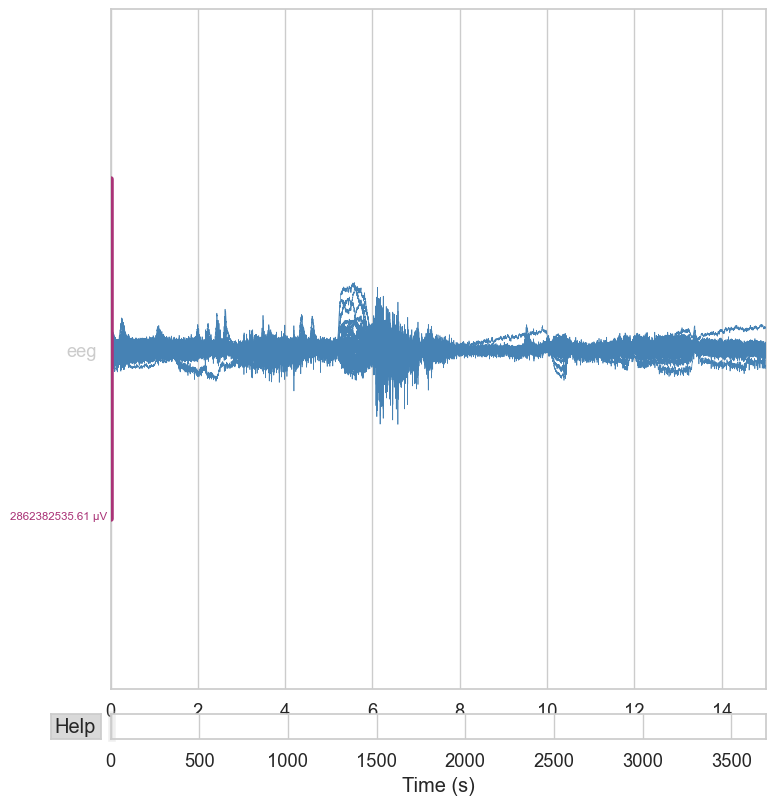

In [17]:
if raw is not None:
    raw.plot(
    duration=15,
    n_channels= min(10, n_channels),            # how many channels to plot vertically
    remove_dc=True,
    butterfly=True,    # Setting this true for a butterfly plot
    color={"eeg": "steelblue"},
    bad_color="red",          # color for bad channels if any
    show=True,
    block=True,
    title="Raw EEG (Initial)",
    scalings="auto"
)

First 5 events:
 [[ 28024      0      0]
 [ 29420      0      0]
 [ 82903      0      0]
 [ 83989      0      0]
 [133910      0      0]]


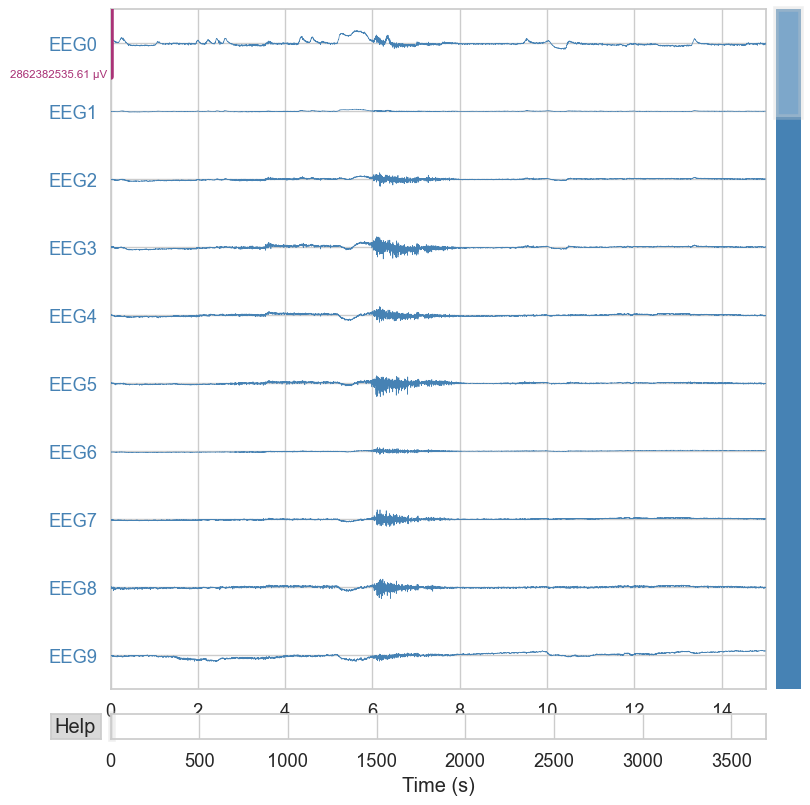

In [18]:
print("First 5 events:\n", events[:5])
if raw is not None:
    raw.plot(
        duration=15,
        n_channels=min(10, n_channels),  # how many channels to plot vertically
        remove_dc=True,
        butterfly=False,  # Setting this true for a butterfly plot
        color={"eeg": "steelblue"},
        bad_color="red",  # color for bad channels if any
        show=True,
        block=True,
        title="Raw EEG (Initial)",
        scalings="auto"
    )

### Preprocessing Steps

**Notch Filter and Bandpass filtering**

In [19]:
notch_freq = 50
raw.notch_filter(freqs=[notch_freq], picks='eeg')

# Bandpass 1-40 Hz
raw.filter(l_freq=1.0, h_freq=40.0, picks='eeg')

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


<RawArray | 63 x 3691800 (3691.8 s), ~1.73 GB, data loaded>

**ICA Artifact Removal**

In [20]:
ica = ICA(n_components=20, random_state=42)
ica.fit(raw)

try:
    eog_indices, scores = ica.find_bads_eog(raw)
    print("Blink components:", eog_indices)
    ica.exclude = eog_indices
except RuntimeError as e:
    if "No EOG channel(s) found" in str(e):
        print("No EOG channels found, skipping find_bads_eog.")
    else:
        raise e

# Now apply ICA regardless
raw_clean = ica.apply(raw.copy())

Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 55.1s.
No EOG channels found, skipping find_bads_eog.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 63 PCA components


**DownSampling**

In [21]:
raw_clean.resample(200)
print("Downsampled to:", raw_clean.info['sfreq'], "Hz")

Downsampled to: 200.0 Hz


**Epoching**



In [22]:
# TODO: adjusting tmin, tmax according to dataset experimental design
# currently set to a range of 5 sec because of above plots
if events is not None:
    tmin, tmax = 0.0, 5.0
    epochs = mne.Epochs(raw_clean, events=events, tmin=tmin, tmax=tmax,
                        baseline=None, preload=True)
    print("Number of epochs:", len(epochs))
else:
    print("No events available. Skipping epoching.")
    epochs = None

Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 160 events and 1001 original time points ...
130 bad epochs dropped
Number of epochs: 30


**Normalisation**

In [23]:
if epochs is not None:
    data = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
    # Normalize each epoch
    for i in range(data.shape[0]):
        ch_means = np.mean(data[i], axis=1, keepdims=True)
        ch_stds = np.std(data[i], axis=1, keepdims=True)
        data[i] = (data[i] - ch_means) / (ch_stds + 1e-8)  # small epsilon to avoid /0

    epochs_normalized = mne.EpochsArray(data, info=epochs.info, events=epochs.events)
    print("Normalization complete. Normalized epochs shape:", epochs_normalized.get_data().shape)
else:
    epochs_normalized = None
    print("No epochs to normalize.")

Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Normalization complete. Normalized epochs shape: (30, 63, 1001)


Visual check of data pre vs post cleaning

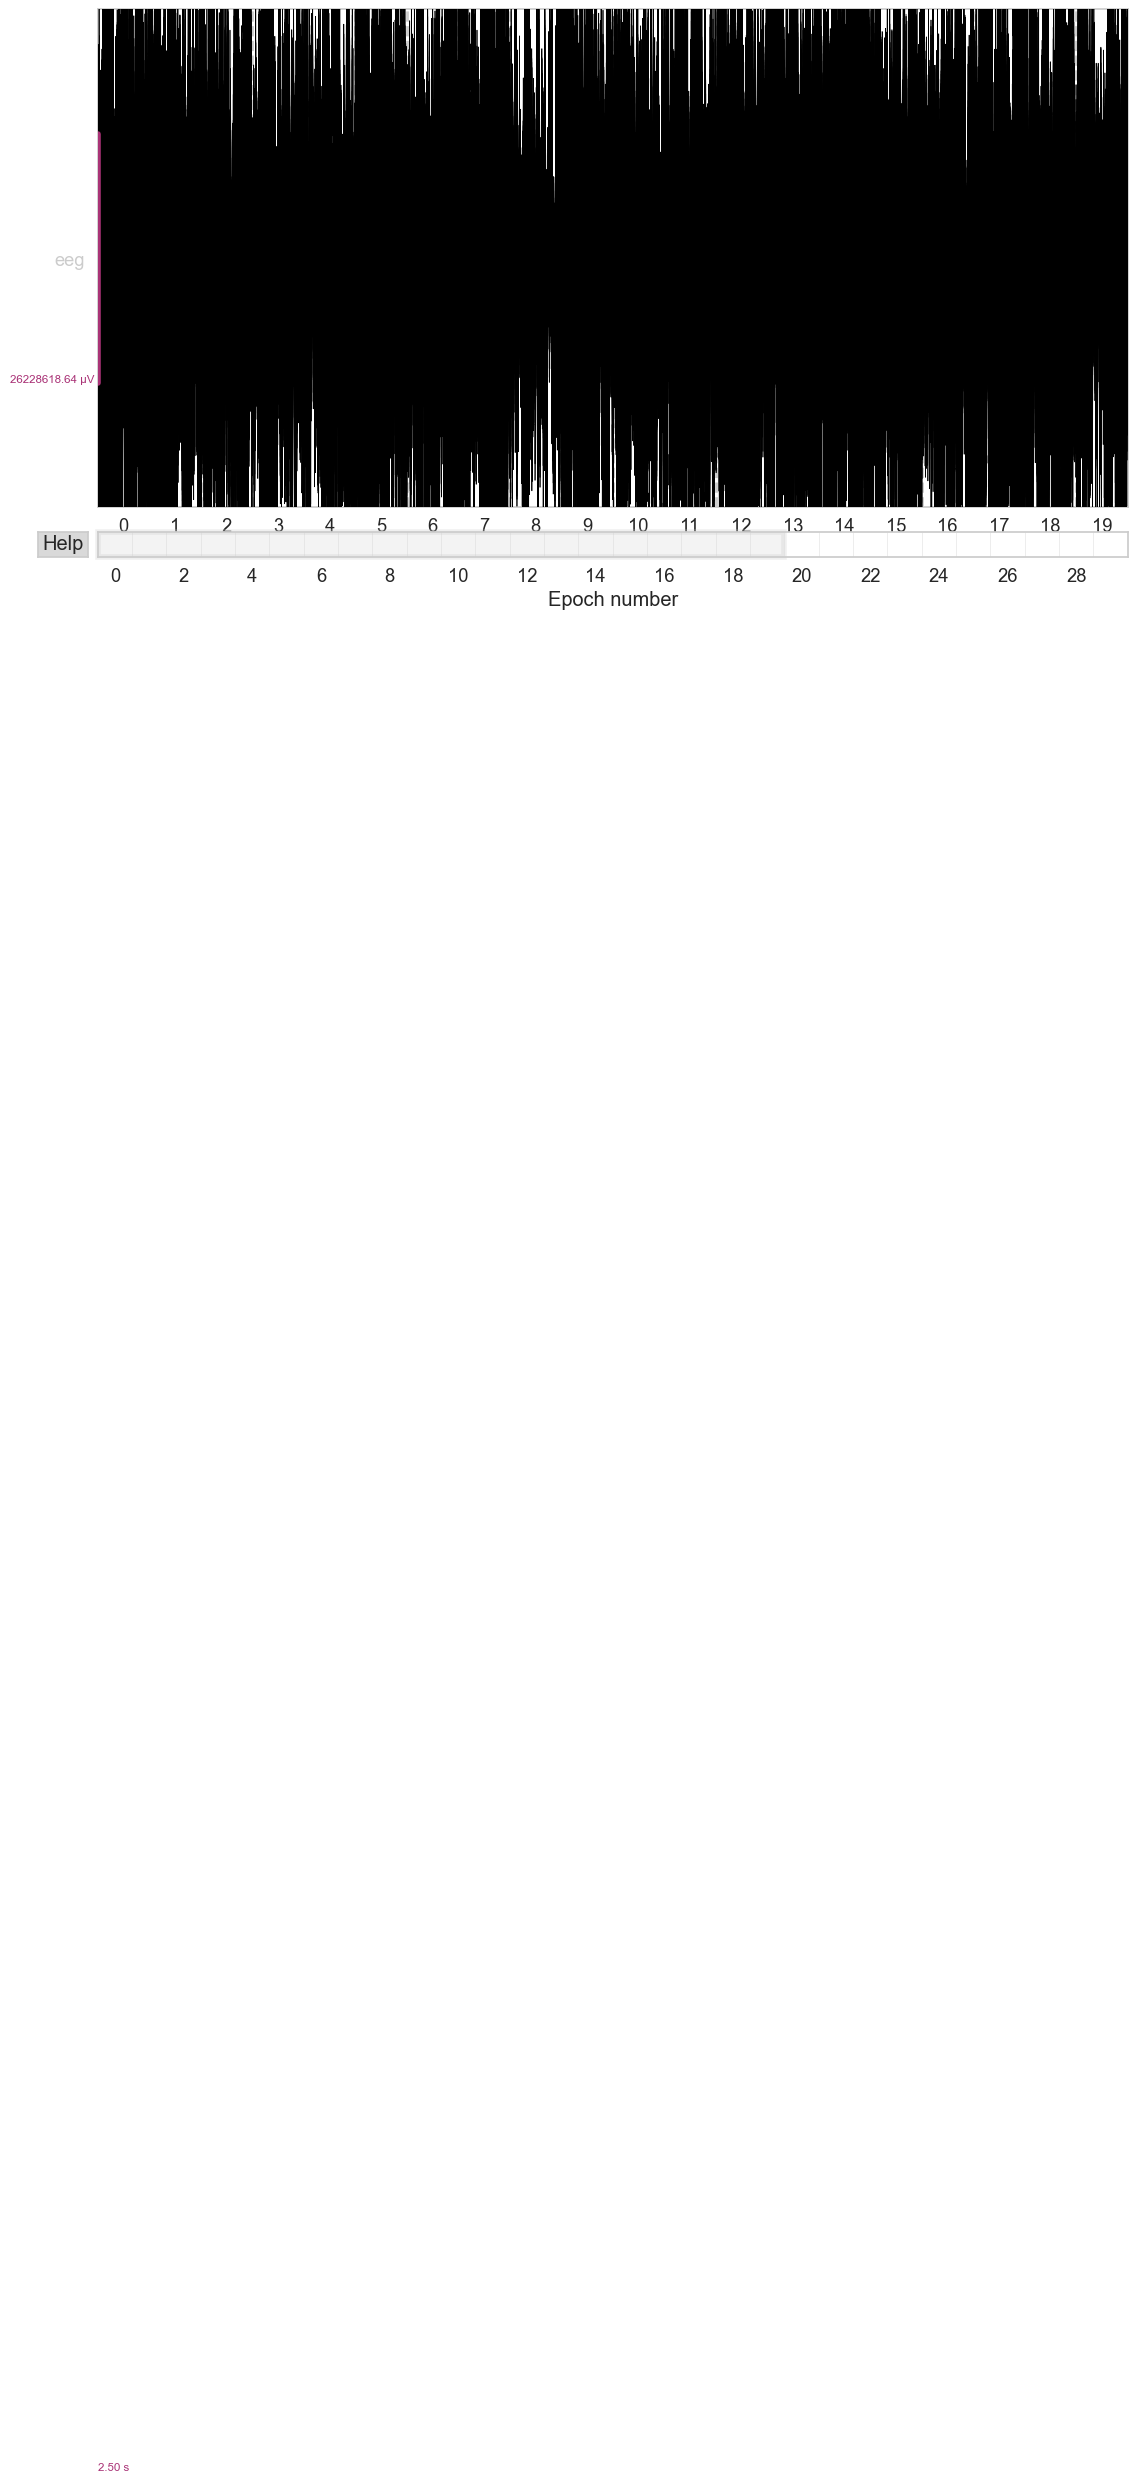

In [32]:
# Plot the original filtered & ICA-cleaned epochs
if epochs is not None:
    fig1 = epochs.plot(
        n_channels=5,                 # number of channels to show
        picks='eeg',                  # just EEG channels
        scalings='auto',              # automatic scaling per channel
        title="Original Filtered & ICA Cleaned (Epochs)",
        show=False,                   # don't show immediately
        block=False,                  # don't block execution
        butterfly=True,              # stacked plot rather than butterfly
        # color={"eeg": "steelblue"},   # custom color for EEG
    )
    # Set the figure size (width=12in, height=6in)
    fig1.set_size_inches(12, 6)
    plt.show()


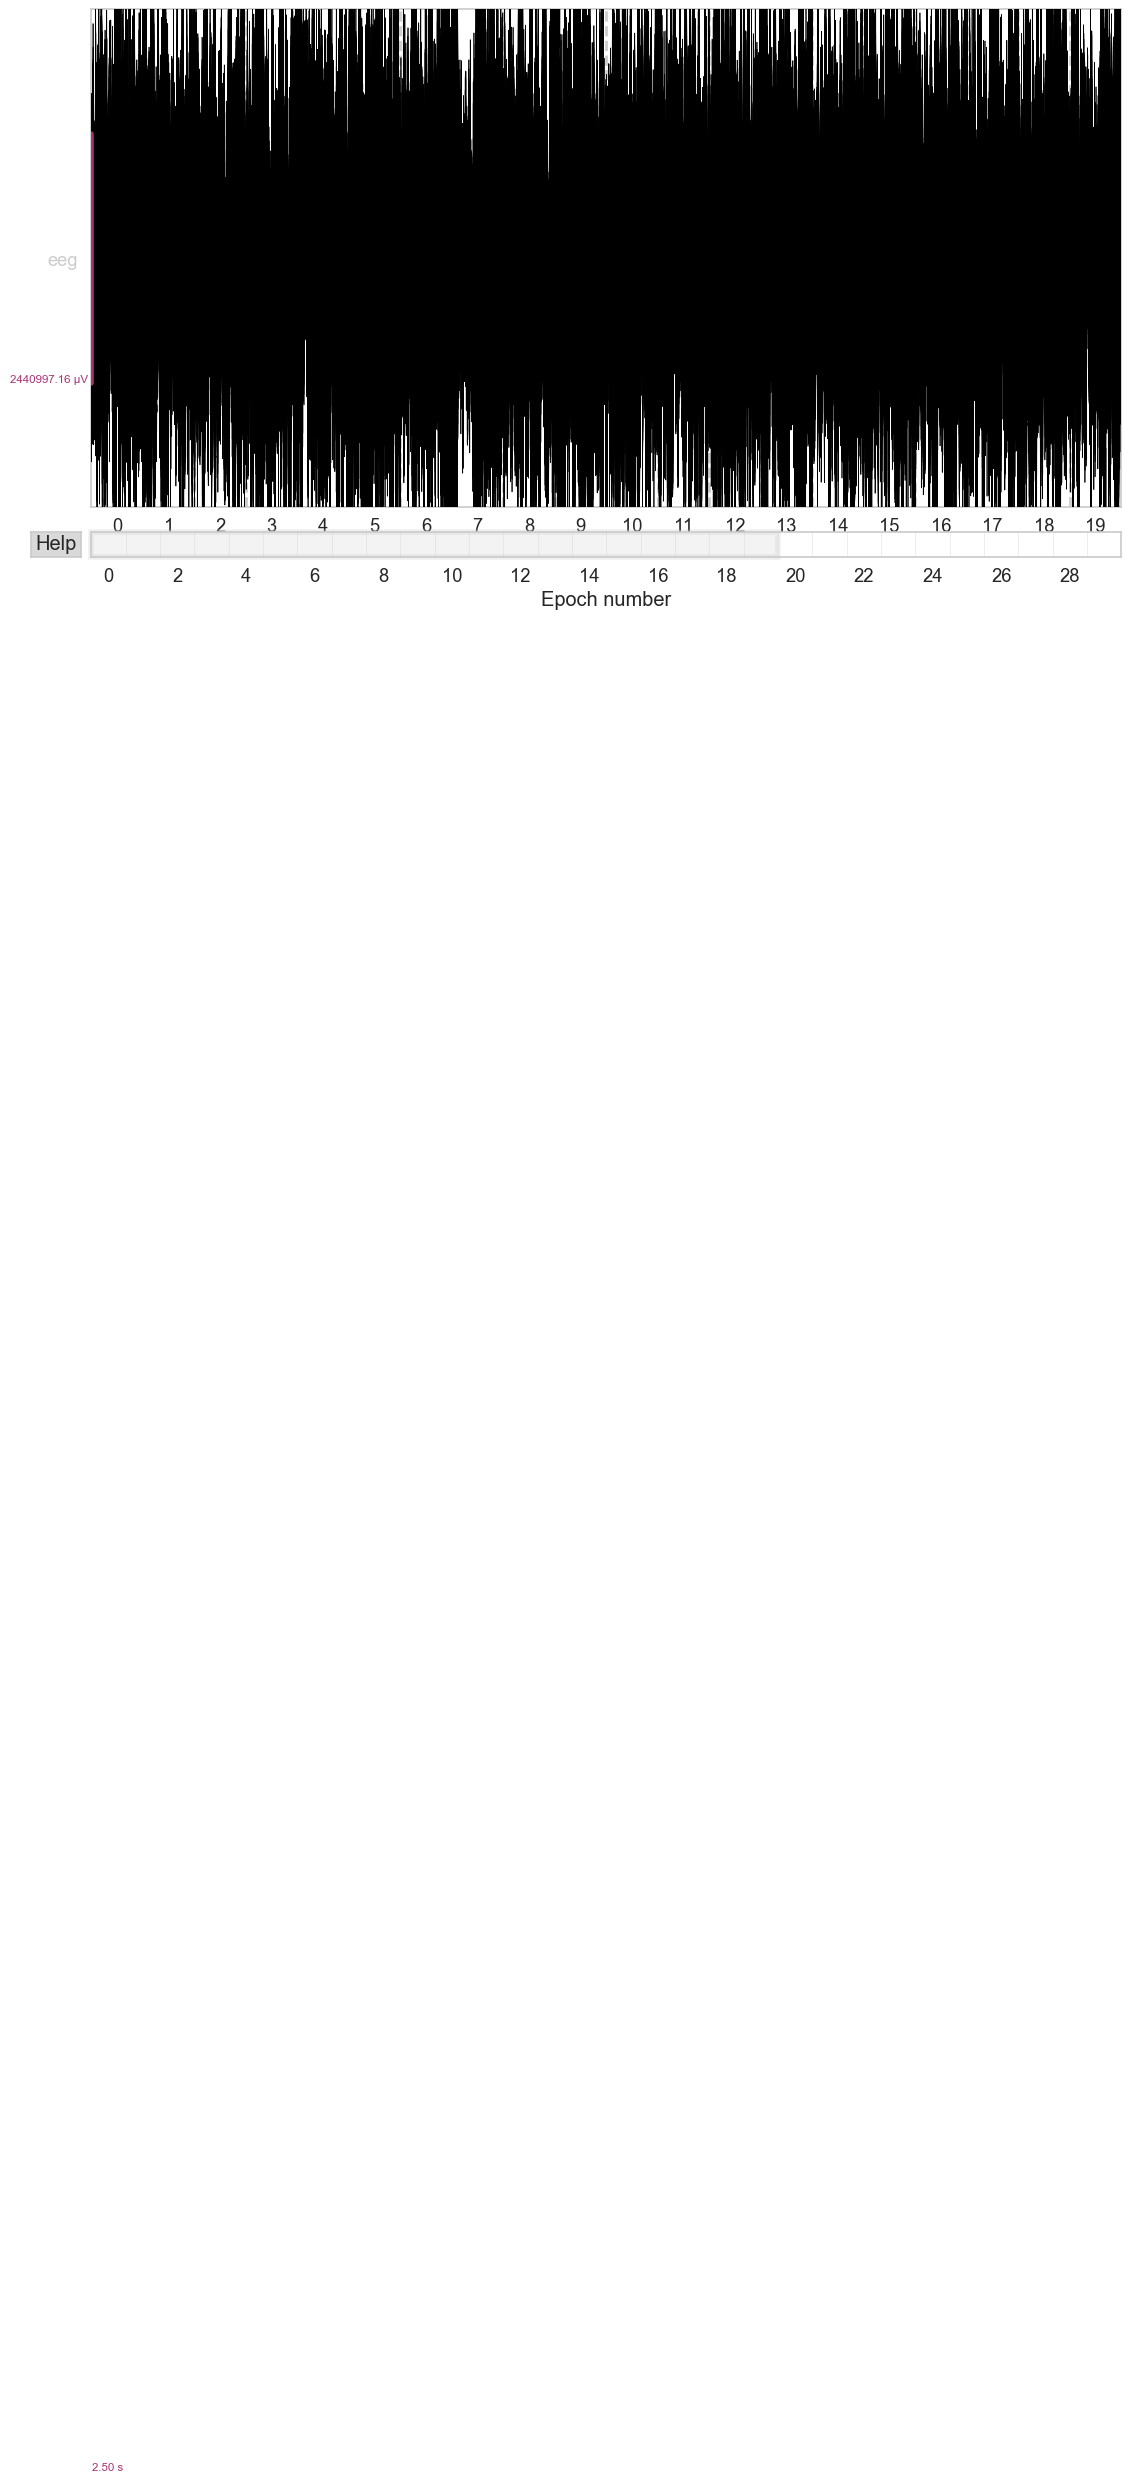

In [31]:
# Plot the normalized epochs
if epochs_normalized is not None:
    fig2 = epochs_normalized.plot(
        n_channels=5,
        picks='eeg',
        scalings='auto',
        title="Normalized Epochs",
        show=False,
        block=False,
        butterfly=True,
        # color={"eeg": "forestgreen"},  # another color example
    )
    fig2.set_size_inches(12, 6)
    plt.show()